In [1]:
from __future__ import print_function
import sys,os,datetime
import cv2 as cv
import cv2 as cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm
import csv

In [2]:
print('openCV',cv.__version__)
print('numpy',np.__version__)

openCV 3.2.0
numpy 1.13.3


In [3]:
dirTrain1 = '../Data/train/train/level-1'
dirTrain2 = '../Data/train/train/level-2'
dirTrain3 = '../Data/train/train/level-3'
dirTrain  = dirTrain2
dirDev    = '../Data/dev/dev'

In [4]:
def NNTrain(dirTrain) :
    listTrain= os.listdir(dirTrain); len(listTrain); listTrain[:12]
    listTrainNN = []
    for ff in listTrain :
        if ff.lower().endswith('.txt') : listTrainNN.append(ff.split('_')[0])
    return(listTrainNN)
listTrainNN = NNTrain(dirTrain)
len(listTrainNN), listTrainNN[:15]

(1495,
 ['1003',
  '1009',
  '100',
  '1012',
  '1018',
  '1021',
  '984',
  '994',
  '995',
  '997',
  '9',
  '952',
  '955',
  '956',
  '959'])

(390, 390, 3) (500, 500, 3) (390, 390) ../Data/train/train/level-1
751 302 213.09587217 36.0 489.453206012 0.140102480059 1.72123602893


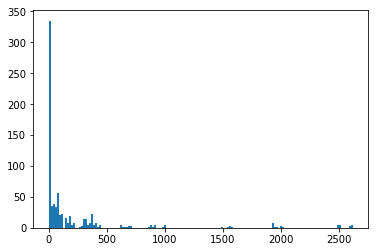

(390, 390, 3) (500, 500, 3) (390, 390) ../Data/train/train/level-2
1495 540 258.478929766 47.0 544.611454936 0.169940124764 1.72846811308


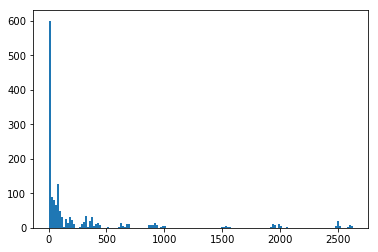

(390, 390, 3) (500, 500, 3) (390, 390) ../Data/train/train/level-3
1873 540 258.515750133 60.0 542.370915742 0.169964332764 1.7258382643


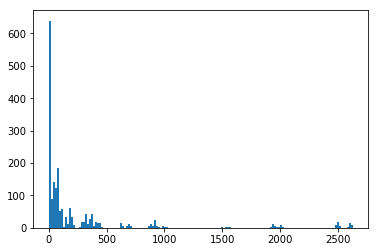

In [6]:
# Build statistics on masks
for dirTrain in (dirTrain1,dirTrain2,dirTrain3) :
    listTrainNN = NNTrain(dirTrain)
    maskSize = []
    for NN in range(len(listTrainNN)) :
        #print(NN)
        img1 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'.tif'),-1)
        img2 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_ref.tif'),-1)
        img3 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_mask.tif'),-1)
        maskSize.append(img3[img3>0.5].size)
        #img1      = cv.GaussianBlur(img1,(3,3),0)
        #img2      = cv.GaussianBlur(img2,(3,3),0)
    print(img1.shape,img2.shape,img3.shape, dirTrain)
    
    maskSize = np.array(maskSize)
    print(len(maskSize), len(maskSize[maskSize==0]), maskSize.mean(), np.median(maskSize), maskSize.std(), maskSize.mean()/(390*390)*100.0, float(maskSize.max())/(390*390)*100.0)
    plt.hist(maskSize,bins=150); plt.show()

In [7]:
def diffPicts (img1, img2) :
    diff = []
    for cc in range(img1.shape[2]) :
        ccc   = np.abs(img1[:,:,cc]-img2[:,:,cc])
        cccL2 = np.sqrt(np.square(ccc).mean())
        cccL1 = ccc.max()
        diff.append([cccL1,cccL2,ccc])
    diffL2 = np.zeros(ccc.shape)
    for L1,L2,ccc in diff : diffL2 += np.square(ccc)
    diffL2 = np.sqrt(diffL2)
    return(diff,diffL2)

def minDeltaRC (img1,img2, ranging=range(-5,6), printOK=False) :
    r0,c0 = (img2.shape[0]-img1.shape[0])/2, (img2.shape[1]-img1.shape[1])/2
    minL2 = [390*390*250.0,0,0]
    for dr in ranging :
        for dc in ranging :
            imgX2 = img2[r0+dr:r0+img1.shape[0]+dr,c0+dc:c0+img1.shape[1]+dc,:]
            diff, L2 = diffPicts(img1,imgX2)
            if (minL2[0]>L2.mean()) : minL2 = (L2.mean(),dr,dc,r0+dr,c0+dc)
            if printOK : print (dr,dc,'\t',minL2[0],'\t',L2.max(),L2.mean(),L2.std(),np.median(L2))
    return(minL2)

print('min=',minDeltaRC(img1,img2))

min= (8.7705751775521197, 0, 1, 55, 56)


In [8]:
def pictNorm (img255, std=False) :
    imgF32 = np.float32(img255) 
    for cc in range(img255.shape[2]) :
        imgF32[:,:,cc] -= imgF32[:,:,cc].mean()
        if std : imgF32[:,:,cc] /= imgF32[:,:,cc].std()**2
        imgF32[:,:,cc] /= 127.0
    return(imgF32)

In [9]:
def computeORB (img, debug=False) :
    orb    = cv2.ORB_create();
    kp     = orb.detect(img,None)
    kp,des = orb.compute(img,kp)
    if debug :
        print (len(kp))
        print (len(des),len(des[0]),"\n",des[0],"\n",des[1])
    return kp,des

def computeMatches (des1,des2) :
    if True :
        bf      = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
        matches = bf.match(des1,des2);
        #????matches = bf.knnMatch(des1,des2,k=1);
    if False :
        index_params = dict(algorithm = 6, #cv2.FLANN_INDEX_LSH,
                            table_number = 6, 
                            key_size = 12,    
                            multi_probe_level = 1)
        search_params = dict(checks=100)
        flann   = cv2.FlannBasedMatcher(index_params,search_params)
        matchesI = flann.knnMatch(des1,des2,k=3);
        matches  = [];
        for mI in matchesI :
            for m in mI : matches.append(m);
    return matches    

def drawMatches(img1,kp1,des1,img2,kp2,des2, show=False, showNN=20):
    matches = computeMatches(des1,des2);
    matches = sorted(matches,key=lambda x:x.distance)
    if  show :
        imgM    = img1.copy()
        #imgM    = cv2.drawMatches(img1,kp1,img2,kp2,matches[:20],imgM,flags=4)
        imgM    = cv2.drawMatches(img1,kp1,img2,kp2,matches[:showNN],imgM,flags=2) #4)
        #imgM    = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,imgM,flags=2) #4)
        
        plt.figure(figsize=(15,15)); plt.imshow(imgM), plt.show()
    return(matches)


In [10]:
len(listTrainNN)

1873

In [137]:
shape2D = (416,416)
X1 = np.zeros((len(listTrainNN),)+shape2D+(3,),dtype=np.float32)
X2 = np.zeros((len(listTrainNN),)+shape2D+(3,),dtype=np.float32)
YY = np.zeros((len(listTrainNN),)+shape2D+(1,),dtype=np.float32)
X1.shape, X2.shape,YY.shape

((1873, 416, 416, 3), (1873, 416, 416, 3), (1873, 416, 416, 1))

In [138]:
416-390

26

In [80]:
print(datetime.datetime.now())

shape2D = (416,416)

for ii,dirTrain in enumerate((dirTrain1,dirTrain2,dirTrain3)) :
    
    #if ii==1 : break
    
    listTrainNN = NNTrain(dirTrain)

    X1 = np.zeros((len(listTrainNN),)+shape2D+(3,),dtype=np.float32)
    X2 = np.zeros((len(listTrainNN),)+shape2D+(3,),dtype=np.float32)
    YY = np.zeros((len(listTrainNN),)+shape2D+(1,),dtype=np.float32)
    print(datetime.datetime.now(),X1.shape, X2.shape,YY.shape,dirTrain)
    
    for NN in range(len(listTrainNN)) :
        img1 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'.tif'),-1)
        img2 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_ref.tif'),-1)
        img3 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_mask.tif'),-1); img3 = img3.reshape(img3.shape+(1,))



        if 1 :
            img1 = cv2.GaussianBlur(img1,(3,3),0)
            img2 = cv2.GaussianBlur(img2,(3,3),0)

        if 0 :
            img1 = cv2.boxFilter(img1,-1,(5,5))
            img2 = cv2.boxFilter(img2,-1,(5,5))


        if 1 :
            img1  = pictNorm(img1)
            img2  = pictNorm(img2)

        rcL2,_,_,r0,c0 = minDeltaRC(img1,img2,ranging=range(-10,10))
        img2X = img2[r0:r0+img1.shape[0],c0:c0+img1.shape[1]]

        if NN%100==0 : print(datetime.datetime.now(),NN,rcL2,r0,c0)

        if 0 :
            img1 = cv2.GaussianBlur(img1,(3,3),0)
            img2X = cv2.GaussianBlur(img2X,(3,3),0)

        if 1 :
            img1  = cv2.boxFilter(img1, -1,(5,5))
            img2X = cv2.boxFilter(img2X,-1,(5,5))

        X1[NN,13:13+390,13:13+390,:], X2[NN,13:13+390,13:13+390,:], YY[NN,13:13+390,13:13+390,:] = img1, img2X, img3


    if 1 :
        np.save(os.path.join(dirForSave,'X1-'+str(ii)+'.npy'),X1)
        np.save(os.path.join(dirForSave,'X2-'+str(ii)+'.npy'),X2)
        np.save(os.path.join(dirForSave,'YY-'+str(ii)+'.npy'),YY)
        print(datetime.datetime.now(),'Save:',X1.shape, X2.shape,YY.shape,dirTrain)
        
print(datetime.datetime.now())

2018-02-12 08:26:44.394974
2018-02-12 08:26:44.399563 (751, 416, 416, 3) (751, 416, 416, 3) (751, 416, 416, 1) ../Data/train/train/level-1
2018-02-12 08:26:45.352151 0 0.0658074848063 55 56
2018-02-12 08:28:17.167419 100 0.0567938326306 56 56
2018-02-12 08:29:41.904455 200 0.0676420703097 56 53
2018-02-12 08:31:06.054255 300 0.0566413581779 54 50
2018-02-12 08:32:30.244880 400 0.0549176484386 46 64
2018-02-12 08:33:54.280129 500 0.0510736484509 54 56
2018-02-12 08:35:18.188724 600 0.0628774579128 55 55
2018-02-12 08:36:42.517704 700 0.205298348405 55 52
2018-02-12 08:37:41.104001 Save: (751, 416, 416, 3) (751, 416, 416, 3) (751, 416, 416, 1) ../Data/train/train/level-1
2018-02-12 08:37:41.244491 (1495, 416, 416, 3) (1495, 416, 416, 3) (1495, 416, 416, 1) ../Data/train/train/level-2
2018-02-12 08:37:42.200435 0 0.135193295812 55 55
2018-02-12 08:39:49.218562 100 0.110332033177 55 55
2018-02-12 08:41:22.393742 200 0.0446885574285 55 55
2018-02-12 08:42:52.506891 300 0.061369903808 55 54


In [11]:
dirForSave = '../Work'

In [154]:
if 0 :
    np.save(os.path.join(dirForSave,'X1.npy'),X1)
    np.save(os.path.join(dirForSave,'X2.npy'),X2)
    np.save(os.path.join(dirForSave,'YY.npy'),YY)
    
if 0 :
    ii = 0
    X1 = np.load(os.path.join(dirForSave,'X1-'+str(ii)+'.npy'))
    X2 = np.load(os.path.join(dirForSave,'X2-'+str(ii)+'.npy'))
    YY = np.load(os.path.join(dirForSave,'YY-'+str(ii)+'.npy'))
    print(datetime.datetime.now(),'Load: ',ii,X1.shape, X2.shape,YY.shape)
    
if 1 :
    iil = []
    for ii in (0,1,2) :
        YY = np.load(os.path.join(dirForSave,'YY-'+str(ii)+'.npy'))
        iil.append(len(YY))
    iis = int(np.array(iil).sum())
    
    X1 = np.zeros((iis,)+shape2D+(3,),dtype=np.float32)
    X2 = np.zeros((iis,)+shape2D+(3,),dtype=np.float32)
    YY = np.zeros((iis,)+shape2D+(1,),dtype=np.float32)
    
    iis = 0
    
    for ii in (0,1,2) :
        
        T1  = np.load(os.path.join(dirForSave,'X1-'+str(ii)+'.npy'))
        T2  = np.load(os.path.join(dirForSave,'X2-'+str(ii)+'.npy'))
        TT  = np.load(os.path.join(dirForSave,'YY-'+str(ii)+'.npy'))
        
        X1[iis:iis+len(TT)], X2[iis:iis+len(TT)], YY[iis:iis+len(TT)] = T1, T2, TT
        
        iis+= len(TT)
        
        del TT,T1, T2
        
    print(datetime.datetime.now(),'Load: ', X1.shape, X2.shape, YY.shape)
    

2018-02-12 21:06:48.973825 Load:  (4119, 416, 416, 3) (4119, 416, 416, 3) (4119, 416, 416, 1)


In [155]:
X1.shape,X2.shape,YY.shape

((4119, 416, 416, 3), (4119, 416, 416, 3), (4119, 416, 416, 1))

In [60]:
from keras.models import Input, Model
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Concatenate, Activation, Dropout,Add
from keras.layers import Conv2DTranspose, SpatialDropout2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import keras
import keras.backend as K 

In [15]:
sys.path.append('../Python')
from LinkNetBoba import LinkNetBoba

In [16]:
#!/usr/local/bin/python
# -*- coding: utf-8 -*-
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# model LinkNet realization for Keras (TensorFlow?)
#
# from: https://arxiv.org/pdf/1707.03718.pdf
# 
#   Abhishek Chaurasia, Eugenio Culurciello
#   LinkNet: Exploiting Encoder Representations for Efficient Semantic Segmentation
#
#
#
# realizate by Vladimir Sorokin
#
# For FREE use
#
#
# keys: LinkNet, Keras, Boba
#
# 2017-11-25
#
# 2017-12-11 1. The add operator in blockEncoder move after batch operator and after activation operator
#            2. Add batch operator 2th conv2 in blockEncoder   
#
# 2017-12-15 1. Fix bugs with names layers
#            2. Change last layers
#            3. Add activation parameter for last layer
#            4. Add conv2D before last layer
#
# 2018-02-11
#            1. Fix bugs (acti_last --> acti in pre-last activation)
#            2. Add prefix-name parameter
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from keras.models import Input, Model
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Concatenate, Activation, Dropout,Add
from keras.layers import Conv2DTranspose, SpatialDropout2D
from keras.layers.normalization import BatchNormalization

def LinkNetBoba (img_shape, n_out=1, depth=4, 
                 acti='elu', acti_last='sigmoid', 
                 dropout=False, batch=True, 
                 prefix='boba',printOK=False):
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Encoder block
    #
    
    def blockEncoder(i, depth, maxDepth, mm, nn) :
        
        io = i
        
        #print('e 0 depth=',depth,io.shape)
        
        io = Conv2D(nn, (3, 3), strides=2, padding='same', name=prefix+"_"+'conv1d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath1d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)
        
        #print('e 1 depth=',depth,io.shape)
        
        io = Conv2D(nn, (3, 3), padding='same', name=prefix+"_"+'conv2d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath2d'+str(maxDepth-depth))(io)
        
        ii = Conv2D(nn, (1, 1), strides=2, name=prefix+"_"+'ii1d'+str(maxDepth-depth))(i)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath3d'+str(maxDepth-depth))(io) # 2017-12-11 add batch
        
        io = Add()([io, ii]); io1 = io;
        
        io = Activation(acti)(io)   # 2017-12-11 change point add before activation after batch
        
        io = Conv2D(nn, (3, 3), padding='same', name=prefix+"_"+'conv3d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath4d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)                
        
        io = Conv2D(nn, (3, 3), padding='same', name=prefix+"_"+'conv4d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath5d'+str(maxDepth-depth))(io)
        
        io = Add()([io, io1]);     # 2017-12-11 change point add before activation after batch
        
        io = Activation(acti)(io)                
        
        ##io = Concatenate()([io, io1]);
        
        return (io)
        

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Decoder block
    #
    
    def blockDecoder(i, depth, maxDepth, mm, nn) :
        
        io = i
        
        io = Conv2D(mm//4, (1, 1), padding='same', name=prefix+"_"+'convd1d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bathd1d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)                
        
        io = Conv2DTranspose(mm//4, (3, 3), padding='same', name=prefix+"_"+'convd2d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bathd2d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)    
        
        io = UpSampling2D((2,2))(io)
        
        io = Conv2D(nn, (1, 1), padding='same', name=prefix+"_"+'convd3d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bathd3d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)                
        
        return (io)
        

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Level block (recursive call build levels) 
    #
    
    def blockLevel(i, depth, maxDepth):

        #if batch : m = BatchNormalization(name='bath1d'+str(maxDepth-depth))(m)
        #if batch and depth==maxDepth : m = BatchNormalization(name='bath1d'+str(maxDepth-depth))(m)
        
        if depth == maxDepth : return(i);
        
        emm, enn =  emm0[depth-1],  enn0[depth-1]
        dmm, dnn =  dmm0[depth-1],  dnn0[depth-1]
        
        #print('l 0 depth=',depth,i.shape)
        en  = blockEncoder(i,depth,maxDepth,emm,enn)
        
        #print('l 1 depth=',depth,en.shape)
        le  = blockLevel(en,depth+1,maxDepth)
        
        
        
        if printOK : print('l 2 depth={} en={} le={}'.format(depth,en.shape,le.shape))
        io  = Add()([en, le]);
        #io  = Concatenate()([en, le]);
        de  = blockDecoder(io,depth,maxDepth,dmm,dnn)
        #print('l L depth=',depth,en.shape)
        
        return de
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Main function block
    #
    
    maxDepth = 4
    depth    = 0
    
    emm0 = [64, 64,128,256]
    enn0 = [64,128,256,512]
    
    ##emm0 = [64, 64,128,256,512]
    ##enn0 = [64,128,256,512,1024]
    
    dmm0 = enn0
    dnn0 = emm0
    
    i = Input(shape=img_shape, name=prefix+"_"+'input'); io = i
    if True : # always exists  
        io = BatchNormalization(name=prefix+"_"+'bath0d'+str(maxDepth-depth))(io)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Initial function block
    #
    
    #print(io.shape)

    io = Conv2D(64, (7, 7), strides=2, padding='same', name=prefix+"_"+'conv1d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath1d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                
        
    io = MaxPooling2D((3, 3), strides=2, name=prefix+"_"+'pool1d'+str(maxDepth-depth))(io)
    
    ##print('before',io.shape)
    
    # levels block
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Main build levels
    #
    
    io = blockLevel(io,depth+1,maxDepth)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Final function block
    #

    io = Conv2DTranspose(32, (3, 3), padding='same', name=prefix+"_"+'conv2d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath2d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                
    
    io = UpSampling2D((2,2))(io)
        
    io = Conv2D(32, (3,3), padding='same', name=prefix+"_"+'conv3d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath3d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                
    
    if dropout : io = SpatialDropout2D(rate=dropout, name=prefix+"_"+'dropLd'+str(maxDepth-depth))(io)
        
    ###io = UpSampling2D((2,2))(io) -- ?????? do bad output result 
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # The End. Build output
    #
    
    io = Conv2DTranspose(n_out, (2, 2), strides=2, padding='same', name=prefix+"_"+'conv4d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath4d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                

    io = Conv2D(n_out, (3,3), padding='same', name=prefix+"_"+'conv5d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath5d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)

    io = Conv2D(n_out, (1,1), padding='same', name=prefix+"_"+'convLd'+str(maxDepth-depth))(io)
    o = Activation(acti_last)(io)

    return Model(inputs=i, outputs=o, name='LinkNetBoba')

if 0 :

    model10 = LinkNetBoba((512,512,3), n_out=1, dropout=0.20, batch=False, acti='elu')
    model10.summary()


In [76]:
def mergeXX (img_shape,n_out=1, acti='elu', dropout=False, batch=True, acti_last='sigmoid') :
    xx1 = LinkNetBoba(img_shape,prefix='boba1',n_out=3,acti_last='tanh')
    xx2 = LinkNetBoba(img_shape,prefix='boba2',n_out=3,acti_last='tanh')

    io = keras.layers.Add()([xx1.output, xx2.output])

    io = Conv2D(8, (3,3), padding='same')(io)
    if batch : io = BatchNormalization()(io)
    io = Activation(acti)(io)

    io = Conv2D(16, (3,3), padding='same')(io)
    if batch : io = BatchNormalization()(io)
    io = Activation(acti)(io)

    io = Conv2D(n_out, (1,1), padding='same')(io)
    o = Activation(acti_last)(io)

    return Model(inputs=[xx1.input,xx2.input], outputs=o, name='LinkNet2Boba')


In [82]:
K.clear_session()
import tensorflow as tf

#--------------------------------------------------------------------------
def F1ScoreCC (truth, pred_, th=None, printOK=False) : # classic realization
    pred = pred_
    if not (th is None) :
        pred = tf.to_float(K.greater(pred_,th))
        
    tp     = K.sum(truth*pred,           axis=(1,2,3))
    fp     = K.sum(K.abs(truth-1.0)*pred,axis=(1,2,3))
    fn     = K.sum(truth*K.abs(pred-1.0),axis=(1,2,3))
    
    #if (tp+fp)>0.0 :precision = tp/(tp+fp)
    #if (fp+fn)>0.0 : recall    = tp/(fp+fn)
    
    tpfp   = tp+fp
    tpfn   = tp+fn

    kUp       = tf.to_float(K.not_equal(0.0,tpfp))
    kDown     = tf.to_float(K.equal    (0.0,tpfp))
    precision = (tp*kUp)/(K.maximum((tp+fp),kDown))

    kUp       = tf.to_float(K.not_equal(0.0,tpfn))
    kDown     = tf.to_float(K.equal    (0.0,tpfn))
    recall    = (tp*kUp)/(K.maximum((tp+fn),kDown))

    prre      = precision+recall

    kUp       = tf.to_float(K.not_equal(0.0,prre))
    kDown     = tf.to_float(K.equal    (0.0,prre))
    fscore = (2.0*precision*recall*kUp)/K.maximum((precision+recall),kDown)
        
    ##dice = K.mean((2.0*x+0.001)/(g+s+0.001),axis=-1)

    
    if printOK : print(K.eval(tp),K.eval(fp),K.eval(fn),K.eval(precision),K.eval(recall),K.eval(fscore))
        
    return(K.clip(fscore, 0.0, 1.0))


def F1ScorePP (truth, pred_, th=None, th1=0.55, th1sum=0.1, kernel=31) :
    
    pred = pred_
    if not (th is None) :
        pred = tf.to_float(K.greater(pred_,th))
        
    one15  = K.ones((kernel,kernel,1,1))
    one15s = kernel*kernel

    def convHV(truth,pred,axis=-1) :
        #tp     = K.sum(truth*pred,axis=(1,2,3))
        #fp     = K.sum(K.abs(truth-1.0)*pred)
        #fn     = K.sum(K.abs(truth-1.0)*K.abs(pred-1.0))
        
        tp     = K.conv2d(truth*pred,                       one15,strides=(1,1),padding='same',dilation_rate=None)
        fp     = K.conv2d(K.abs(truth-1.0)*pred,            one15,strides=(1,1),padding='same',dilation_rate=None)
        fn     = K.conv2d(truth*K.abs(pred-1.0),            one15,strides=(1,1),padding='same',dilation_rate=None)
        
        #print(K.eval(tp),K.eval(fp),K.eval(fn))
        
        tpfp   = tp+fp
        tpfn   = tp+fn
        
        kUp       = tf.to_float(K.not_equal(0.0,tpfp))
        kDown     = tf.to_float(K.equal    (0.0,tpfp))
        precision = (tp*kUp)/(K.maximum((tp+fp),kDown))
        
        kUp       = tf.to_float(K.not_equal(0.0,tpfn))
        kDown     = tf.to_float(K.equal    (0.0,tpfn))
        recall    = (tp*kUp)/(K.maximum((tp+fn),kDown))
        
        prre      = precision+recall

        kUp       = tf.to_float(K.not_equal(0.0,prre))
        kDown     = tf.to_float(K.equal    (0.0,prre))
        fscore = (2.0*precision*recall*kUp)/K.maximum((precision+recall),kDown)

        return(K.clip(fscore, 0.0, 1.0))
        
    F1Score = convHV(truth,pred)
    
    F1Score = K.mean(F1Score,axis=-1) #dice/(15.0*15.0)
    
    # ????dd        = K.clip(tf.to_float(K.greater(dice,th1))+th1sum,th1sum,1.0)
    # ????dice      = dice*dd
    
    return(K.clip(F1Score, 0.0, 1.0))


def f1scoreTF (truth, pred, th=0.5) :
    return(F1ScoreCC(truth,pred,th=th))

def lossXf1 (truth,pred) :
    return(keras.losses.binary_crossentropy(truth,pred) - K.log(F1ScorePP(truth,pred)))

def lossYf1 (truth,pred) :
    #return( - K.log(F1ScoreCC(truth,pred) ))
    return( 1.0 - F1ScorePP(truth,pred))

In [83]:
model10 = mergeXX((416,416,3))
model10.compile(loss='binary_crossentropy', #lossXf1, #'binary_crossentropy',
              optimizer='adam', #sgd, #"adam", #'rmsprop',
              metrics=['binary_accuracy',F1ScoreCC]) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
boba1_input (InputLayer)         (None, 416, 416, 3)   0                                            
____________________________________________________________________________________________________
boba2_input (InputLayer)         (None, 416, 416, 3)   0                                            
____________________________________________________________________________________________________
boba1_bath0d4 (BatchNormalizatio (None, 416, 416, 3)   12          boba1_input[0][0]                
____________________________________________________________________________________________________
boba2_bath0d4 (BatchNormalizatio (None, 416, 416, 3)   12          boba2_input[0][0]                
___________________________________________________________________________________________

In [161]:
print(datetime.datetime.now())

epochs     = 40 #60
verbose    = 2
batch_size = 6
batch_size = 16

metric     = 'F1ScoreCC'

path       = YY.shape[0] #750

filepath="../Temp/V02-val_"+metric+"={val_"+metric+":.4f}-({"+metric+":.4f}).hdf5"
#checkpoint1 = ModelCheckpoint(filepath, monitor=metric,        verbose=1, save_best_only=True, mode='max')
#checkpoint1 = ModelCheckpoint(filepath, monitor=metric,        verbose=1, save_best_only=True, mode='max')
checkpoint2 = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')

reduce_lr1     = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=4, min_lr=0.000001,verbose=1)
reduce_lr2     = ReduceLROnPlateau(monitor='loss',     factor=0.1,patience=2, min_lr=0.000001,verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',     patience=6,min_delta=0.0001,verbose=1)

#hist1  = model10.fit([X1[:path],X2[:path]],YY[:path],
hist1  = model10.fit([X1,X2],YY,
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.20, 
                    #validation_data=(ttrainX[2300:],ttrainY[2300:]),
                    initial_epoch = 40,
                    #callbacks=[early_stopping,reduce_lr1,reduce_lr2,checkpoint],
                    #callbacks=[reduce_lr1,reduce_lr2,checkpoint2,early_stopping],
                    callbacks=[reduce_lr1,reduce_lr2,checkpoint2,early_stopping],
                    verbose=verbose)

print(datetime.datetime.now())

2018-02-12 21:37:49.032723
Train on 3295 samples, validate on 824 samples
Epoch 37/40
Epoch 00036: val_F1ScoreCC improved from -inf to 0.28651, saving model to ../Temp/V02-val_F1ScoreCC=0.2865-(0.3215).hdf5
730s - loss: -3.9605e+00 - binary_accuracy: 0.9155 - F1ScoreCC: 0.3215 - val_loss: -2.9200e+00 - val_binary_accuracy: 0.7950 - val_F1ScoreCC: 0.2865
Epoch 38/40
Epoch 00037: val_F1ScoreCC improved from 0.28651 to 0.34150, saving model to ../Temp/V02-val_F1ScoreCC=0.3415-(0.3308).hdf5
738s - loss: -4.2600e+00 - binary_accuracy: 0.9233 - F1ScoreCC: 0.3308 - val_loss: -4.1500e+00 - val_binary_accuracy: 0.9492 - val_F1ScoreCC: 0.3415
Epoch 39/40
Epoch 00038: val_F1ScoreCC did not improve
736s - loss: -4.4649e+00 - binary_accuracy: 0.9310 - F1ScoreCC: 0.3361 - val_loss: -4.4248e+00 - val_binary_accuracy: 0.8965 - val_F1ScoreCC: 0.3253
Epoch 40/40
Epoch 00039: val_F1ScoreCC did not improve
740s - loss: -4.5810e+00 - binary_accuracy: 0.9397 - F1ScoreCC: 0.3428 - val_loss: -3.4700e+00 - val

In [162]:
if 1 :
    print(datetime.datetime.now())
    PP = model10.predict([X1,X2],batch_size=batch_size)
    print(datetime.datetime.now())

2018-02-12 22:30:30.346658
2018-02-12 22:32:53.967950


(4119, 416, 416, 1)


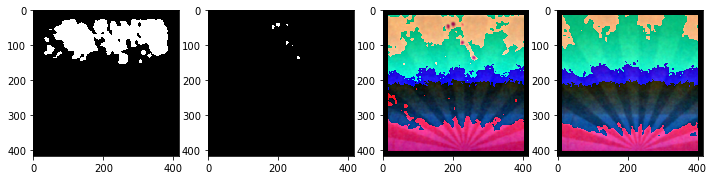

In [164]:
NN = 23
th = 0.999
print(PP.shape)
plt.figure(figsize=(12,5))
ppp = PP[NN].reshape(PP.shape[1:-1]).copy(); ppp[ppp>=th] = 1.0; ppp[ppp<th] = 0.0; 
plt.subplot(1,4,1);  plt.imshow(ppp,'gray');
plt.subplot(1,4,2);  plt.imshow(YY[NN].reshape(YY.shape[1:-1]),'gray');
plt.subplot(1,4,3);  plt.imshow(X1[NN]);
plt.subplot(1,4,4);  plt.imshow(X2[NN]);
plt.show()

In [160]:

#model10.lr.get_value()
K.get_value(model10.optimizer.lr)
K.set_value(model10.optimizer.lr, 0.001)
K.get_value(model10.optimizer.lr)


0.001

In [151]:
12000.0/(390*390)*100.0

7.889546351084813

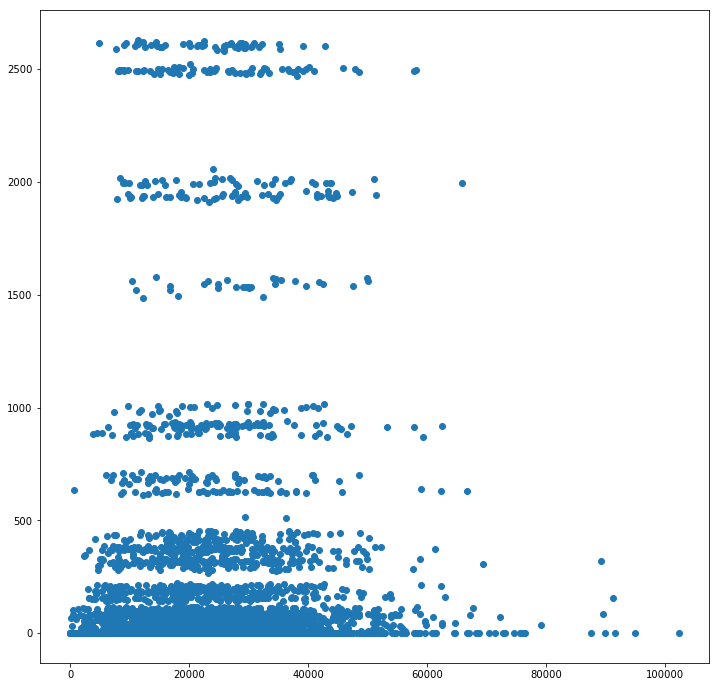

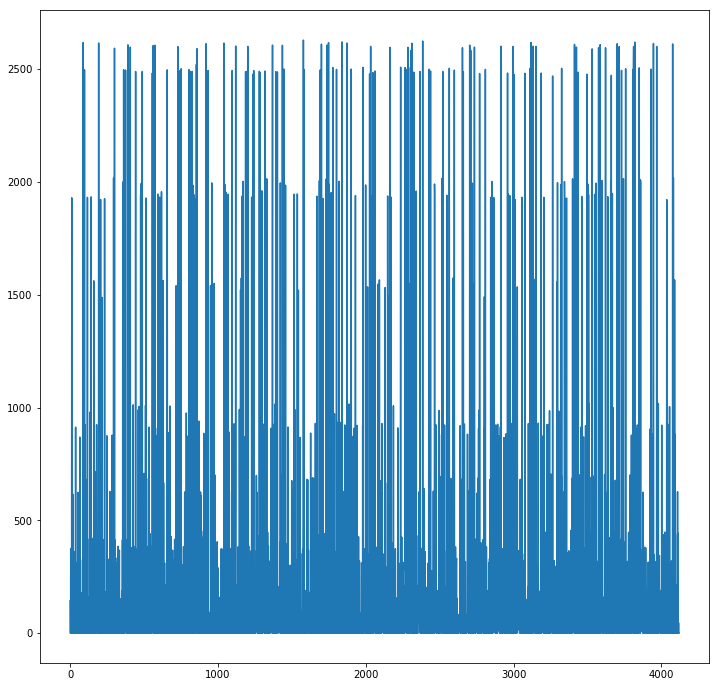

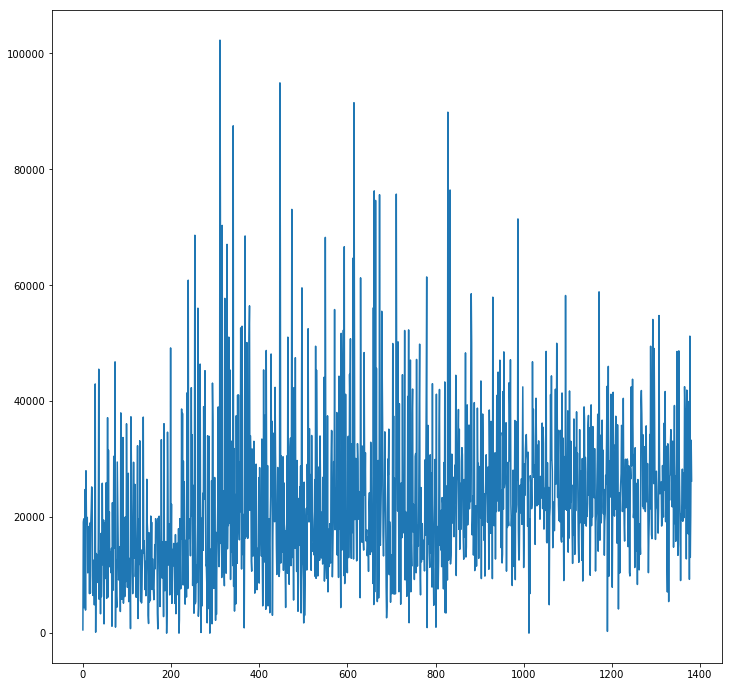

In [165]:
th = 0.5
pl,yl = [],[]
for ppp,yyy in zip(PP,YY) : 
    pl.append(len(ppp[ppp>th]))
    yl.append(len(yyy[yyy>th]))    
    
py = np.array([pl,yl])
plt.figure(figsize=(12,12))
plt.scatter(py[0],py[1]); plt.show()
plt.figure(figsize=(12,12))
plt.plot(py[1]); plt.show()

plt.figure(figsize=(12,12))
plt.plot(py[:,py[1]==0][0]); plt.show()


In [ ]:
    early_stopping = EarlyStopping(monitor='val_loss',     patience=6,min_delta=0.0001,verbose=1)
    reduce_lr1     = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.00000001,verbose=1)
    reduce_lr2     = ReduceLROnPlateau(monitor='loss',     factor=0.5,patience=2, min_lr=0.00000001,verbose=1)

    #filepath="../Temp/V2-UNET-val_"+metric+"={val_"+metric+":.4f}-full.hdf5"
    #filepath="../Temp/V2-UNET-val_"+metric+"={val_"+metric+":.4f}.hdf5"
    #filepath="../Temp/V2-UNETx5-val_"+metric+"={val_"+metric+":.4f}.hdf5"
    filepath="../Temp/V2-UNETx5-val_"+metric+"={val_"+metric+":.4f}-full.hdf5"
    
    checkpoint1 = ModelCheckpoint(filepath, monitor=metric,        verbose=1, save_best_only=True, mode='max')
    checkpoint2 = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')



In [23]:
import tensorflow as tf

#--------------------------------------------------------------------------
def F1ScoreCC (truth, pred_, th=None, printOK=False) : # classic realization
    pred = pred_
    if not (th is None) :
        pred = tf.to_float(K.greater(pred_,th))
        
    tp     = K.sum(truth*pred,           axis=(1,2,3))
    fp     = K.sum(K.abs(truth-1.0)*pred,axis=(1,2,3))
    fn     = K.sum(truth*K.abs(pred-1.0),axis=(1,2,3))
    
    #if (tp+fp)>0.0 :precision = tp/(tp+fp)
    #if (fp+fn)>0.0 : recall    = tp/(fp+fn)
    
    tpfp   = tp+fp
    tpfn   = tp+fn

    kUp       = tf.to_float(K.not_equal(0.0,tpfp))
    kDown     = tf.to_float(K.equal    (0.0,tpfp))
    precision = (tp*kUp)/(K.maximum((tp+fp),kDown))

    kUp       = tf.to_float(K.not_equal(0.0,tpfn))
    kDown     = tf.to_float(K.equal    (0.0,tpfn))
    recall    = (tp*kUp)/(K.maximum((tp+fn),kDown))

    prre      = precision+recall

    kUp       = tf.to_float(K.not_equal(0.0,prre))
    kDown     = tf.to_float(K.equal    (0.0,prre))
    fscore = (2.0*precision*recall*kUp)/K.maximum((precision+recall),kDown)
        
    ##dice = K.mean((2.0*x+0.001)/(g+s+0.001),axis=-1)

    
    if printOK : print(K.eval(tp),K.eval(fp),K.eval(fn),K.eval(precision),K.eval(recall),K.eval(fscore))
        
    return(K.clip(fscore, 0.0, 1.0))


def F1ScorePP (truth, pred_, th=None, th1=0.55, th1sum=0.1, kernel=31) :
    
    pred = pred_
    if not (th is None) :
        pred = tf.to_float(K.greater(pred_,th))
        
    one15  = K.ones((kernel,kernel,1,1))
    one15s = kernel*kernel

    def convHV(truth,pred,axis=-1) :
        #tp     = K.sum(truth*pred,axis=(1,2,3))
        #fp     = K.sum(K.abs(truth-1.0)*pred)
        #fn     = K.sum(K.abs(truth-1.0)*K.abs(pred-1.0))
        
        tp     = K.conv2d(truth*pred,                       one15,strides=(1,1),padding='same',dilation_rate=None)
        fp     = K.conv2d(K.abs(truth-1.0)*pred,            one15,strides=(1,1),padding='same',dilation_rate=None)
        fn     = K.conv2d(truth*K.abs(pred-1.0),            one15,strides=(1,1),padding='same',dilation_rate=None)
        
        #print(K.eval(tp),K.eval(fp),K.eval(fn))
        
        tpfp   = tp+fp
        tpfn   = tp+fn
        
        kUp       = tf.to_float(K.not_equal(0.0,tpfp))
        kDown     = tf.to_float(K.equal    (0.0,tpfp))
        precision = (tp*kUp)/(K.maximum((tp+fp),kDown))
        
        kUp       = tf.to_float(K.not_equal(0.0,tpfn))
        kDown     = tf.to_float(K.equal    (0.0,tpfn))
        recall    = (tp*kUp)/(K.maximum((tp+fn),kDown))
        
        prre      = precision+recall

        kUp       = tf.to_float(K.not_equal(0.0,prre))
        kDown     = tf.to_float(K.equal    (0.0,prre))
        fscore = (2.0*precision*recall*kUp)/K.maximum((precision+recall),kDown)

        return(K.clip(fscore, 0.0, 1.0))
        
    F1Score = convHV(truth,pred)
    
    F1Score = K.mean(F1Score,axis=-1) #dice/(15.0*15.0)
    
    # ????dd        = K.clip(tf.to_float(K.greater(dice,th1))+th1sum,th1sum,1.0)
    # ????dice      = dice*dd
    
    return(K.clip(F1Score, 0.0, 1.0))

def diceCC (truth, pred_, th=None) : # classic realization = inter/union
    pred = pred_
    if not (th is None) :
        pred = tf.to_float(K.greater(pred_,th))
    g, s = K.sum(truth,axis=(1,2,3)), K.sum(pred,axis=(1,2,3))
    x    = K.sum(truth*pred,axis=(1,2,3))
    dice = K.mean((2.0*x+0.001)/(g+s+0.001),axis=-1)
    return(K.clip(dice, 0.0, 1.0))

def dicePP_old (truth, pred, th=None, th1=0.45, th1sum=0.1) :
    
    def diceHV(truth,pred,axis=-1) :
        g, s, x  = K.sum(truth,axis=axis), K.sum(pred,axis=axis), K.sum(truth*pred,axis=axis)
        diceMean = K.mean((2.0*x+1.0)/(g+s+1.0),axis=-1)
        dd       = K.clip(tf.to_float(K.greater(diceMean,th1))+th1sum,th1sum,1.0)
        diceMean = dd*diceMean
        return (diceMean)
        
    diceMean1 = diceHV(truth,pred,axis=(2,3))
    diceMean2 = diceHV(truth,pred,axis=(1,3))
    
    dice      = (diceMean1+diceMean2)/2.0
    dd        = K.clip(tf.to_float(K.greater(dice,th1)),th1sum,1.0)
    dice      = dice*dd
    
    return(K.clip(dice, 0.0, 1.0))

def dicePP (truth, pred, th=None, th1=0.55, th1sum=0.1) :
    
    one15  = K.ones((15,15,1,1))
    one15s = 15.0*15.0

    def diceHV(truth,pred,axis=-1) :
        g  = K.conv2d(truth,one15,strides=(1,1),padding='same',dilation_rate=None) #dilation_rate
        s  = K.conv2d(pred ,one15,strides=(1,1),padding='same',dilation_rate=None)
        x  = K.conv2d(truth*pred,one15,strides=(1,1),padding='same',dilation_rate=None)
        diceMean = (2.0*x+0.001)/(g+s+0.001) # /one15s
        dd       = K.clip(tf.to_float(K.greater(diceMean,th1))+th1sum,th1sum,1.0)
        diceMean = diceMean*dd
        return (diceMean)
        
    diceMean1 = diceHV(truth,pred)
    
    dice      = K.mean(diceMean1,axis=-1) #dice/(15.0*15.0)
    
    # ????dd        = K.clip(tf.to_float(K.greater(dice,th1))+th1sum,th1sum,1.0)
    # ????dice      = dice*dd
    
    return(K.clip(dice, 0.0, 1.0))

def dicePP01 (truth, pred, th=0.5) : return(dicePP(truth,pred,th=th))

def dice01 (truth, pred_, th=0.5) :
    pred   = tf.to_float(K.greater(pred_,th))
    return (dicePP(truth,pred))
    
def dicePP01 (truth, pred, th=0.5) : return(dicePP(truth,pred,th=th))

def dice (truth, pred, th=0.5) :
    return(diceCC(truth,pred,th=th))

def f1scoreTF (truth, pred, th=0.5) :
    return(F1ScoreCC(truth,pred,th=th))

def lossXf1 (truth,pred) :
    return(losses.binary_crossentropy(truth,pred) - K.log(F1ScorePP(truth,pred)))

def lossYf1 (truth,pred) :
    #return( - K.log(F1ScoreCC(truth,pred) ))
    return( 1.0 - F1ScorePP(truth,pred))

def lossXdice (truth,pred) :
    return(losses.binary_crossentropy(truth,pred) - K.log(dicePP01(truth,pred)))

def lossYdice (truth,pred) :
    return( - K.log(dicePP(truth,pred) ))